# An Improved Evolutionary Multi-Objective Clustering Algorithm Based on Autoencoder

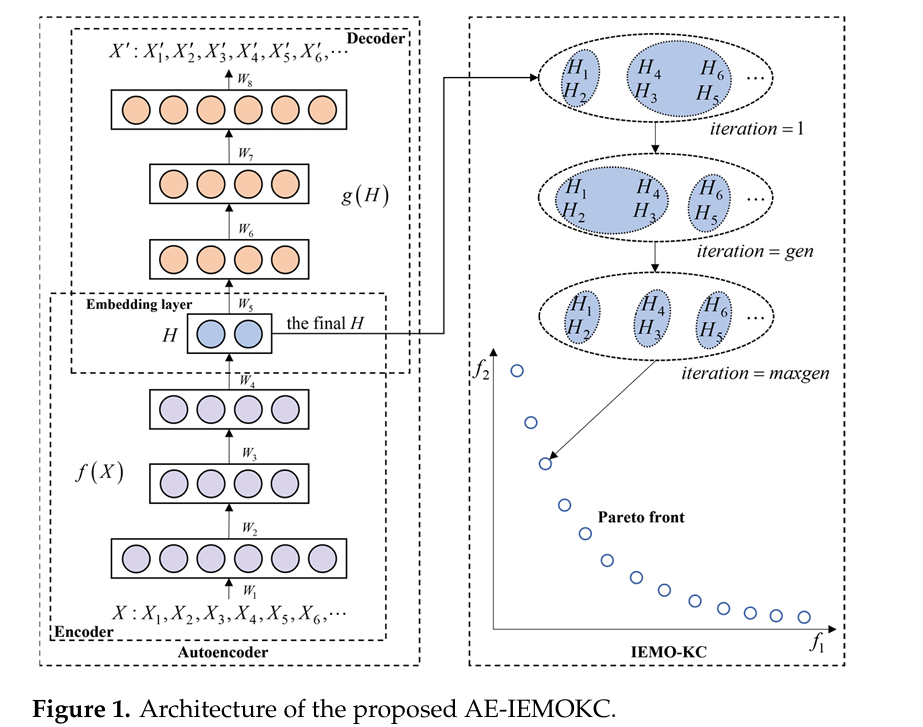

# loading datasets

In [2]:
import pandas as pd

In [3]:
pro_data_mall = pd.read_csv('../Processed_datasets/mall_customer_segmentation/processed_data.csv')
display(pro_data_mall.head())
display(pro_data_mall.info())

,Age,Annual Income (k$),Spending Score (1-100),Gender
0,-1.424569,-1.738999,-0.434801,1
1,-1.281035,-1.738999,1.195704,1
2,-1.352802,-1.700830,-1.715913,0
3,-1.137502,-1.700830,1.040418,0
4,-0.563369,-1.662660,-0.395980,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     200 non-null    float64
 1   Annual Income (k$)      200 non-null    float64
 2   Spending Score (1-100)  200 non-null    float64
 3   Gender                  200 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 6.4 KB


None

In [4]:
auto_data_train = pd.read_csv('../Processed_datasets/utomobile_customer_segmentation/train_processed_data.csv')
auto_data_test = pd.read_csv('../Processed_datasets/utomobile_customer_segmentation/test_processed_data.csv')
display("Training set", auto_data_train.head())
display(auto_data_train.info())
display("Testing set", auto_data_test.head())  
display(auto_data_test.info())

'Training set'

,Age,Work_Experience,Family_Size,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
0,-1.284623,-0.499892,0.757947,1,0,0,5,2,3,3
1,-0.327151,0.537954,0.096095,0,1,1,2,0,3,0
2,1.408268,-0.499892,-1.227610,0,1,1,2,2,5,1
3,1.408268,-0.805141,-0.565758,1,1,1,7,1,5,1
4,-0.207467,1.453700,2.081652,0,1,1,3,1,5,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              8068 non-null   float64
 1   Work_Experience  8068 non-null   float64
 2   Family_Size      8068 non-null   float64
 3   Gender           8068 non-null   int64  
 4   Ever_Married     8068 non-null   int64  
 5   Graduated        8068 non-null   int64  
 6   Profession       8068 non-null   int64  
 7   Spending_Score   8068 non-null   int64  
 8   Var_1            8068 non-null   int64  
 9   Segmentation     8068 non-null   int64  
dtypes: float64(3), int64(7)
memory usage: 630.4 KB


None

'Testing set'

,Age,Work_Experience,Family_Size,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1
0,-0.450948,-0.792867,-1.196222,0,1,1,2,2,5
1,-0.391999,1.696957,0.767498,1,1,1,5,0,5
2,1.494372,-0.792867,-1.196222,0,1,0,0,2,5
3,0.904881,2.630641,-0.541649,1,1,0,4,1,5
4,-1.453083,-0.045920,0.767498,0,0,0,8,2,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              2627 non-null   float64
 1   Work_Experience  2627 non-null   float64
 2   Family_Size      2627 non-null   float64
 3   Gender           2627 non-null   int64  
 4   Ever_Married     2627 non-null   int64  
 5   Graduated        2627 non-null   int64  
 6   Profession       2627 non-null   int64  
 7   Spending_Score   2627 non-null   int64  
 8   Var_1            2627 non-null   int64  
dtypes: float64(3), int64(6)
memory usage: 184.8 KB


None

# Autoencoder (AE)

- Input → 500 → 500 → 2000 → embedding (d*)
- embedding → 2000 → 500 → 500 → output
- ReLU activations (except final layer)

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist


In [13]:
class Autoencoder:
    def __init__(self, input_dim, embedding_dim=3):
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.autoencoder, self.encoder = self._build_network()
        
    def _build_network(self):
        # Encoder
        input_layer = Input(shape=(self.input_dim,))
        x = Dense(500, activation='relu')(input_layer)
        x = Dense(500, activation='relu')(x)
        x = Dense(2000, activation='relu')(x)
        embedding = Dense(self.embedding_dim, activation=None)(x)
        
        # Decoder
        x = Dense(2000, activation='relu')(embedding)
        x = Dense(500, activation='relu')(x)
        x = Dense(500, activation='relu')(x)
        output_layer = Dense(self.input_dim, activation=None)(x)
        
        # Models
        autoencoder = Model(input_layer, output_layer)
        encoder = Model(input_layer, embedding)
        
        return autoencoder, encoder
    
    def pretrain(self, X, epochs=100, batch_size=32):
        self.autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
        self.autoencoder.fit(X, X, epochs=epochs, batch_size=batch_size, verbose=0)
        
    def finetune(self, X, k_true, lambda_cluster=0.001, epochs=200, batch_size=32):
        # Get initial clusters
        H = self.encoder.predict(X)
        kmeans = KMeans(n_clusters=k_true).fit(H)
        centroids = kmeans.cluster_centers_
        
        # Custom loss with clustering
        def total_loss(y_true, y_pred):
            # Reconstruction loss
            rec_loss = tf.reduce_mean(tf.square(y_true - y_pred))
            
            # Clustering loss
            H_pred = self.encoder(y_true)
            dists = tf.stack([tf.reduce_sum(tf.square(H_pred - c), axis=1) for c in centroids])
            min_dists = tf.reduce_min(dists, axis=0)
            cl_loss = tf.square((10.0/(X.shape[0]*self.embedding_dim)) * tf.reduce_sum(min_dists))
            
            return rec_loss + lambda_cluster * cl_loss
        
        self.autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss=total_loss)
        self.autoencoder.fit(X, X, epochs=epochs, batch_size=batch_size, verbose=0)

In [19]:
class IEMOKC:
    def __init__(self, k_range=(2,15), pop_size=100, max_gen=500):
        self.k_min, self.k_max = k_range
        self.pop_size = pop_size
        self.max_gen = max_gen
        
    def _initialize_population(self, data):
        pop = []
        for _ in range(self.pop_size):
            # Valid initialization: select actual data points as centroids
            idx = np.random.choice(len(data), size=self.k_max, replace=False)
            chromosome = data[idx].flatten()
            pop.append(chromosome)
        return np.array(pop)
    
    def _evaluate(self, solution, data, k):
        centroids = solution.reshape(self.k_max, -1)[:k]  # Use first k centroids
        dists = cdist(data, centroids, 'euclidean')
        min_dists = np.min(dists, axis=1)
        ssd = np.sum(min_dists**2)
        
        alpha = 10/(len(data)*data.shape[1])  # Scaling factor
        ssd_exp = (1 - np.exp(-alpha * ssd)) - k
        
        return ssd_exp, k
    def _non_dominated_sort(self, fitness):
        # Implement NSGA-II non-dominated sorting
        fronts = [[]]
        dominated_counts = [0]*len(fitness)
        dominates = [[] for _ in range(len(fitness))]
        
        # Convert fitness to numpy array for vectorized operations
        fitness_array = np.array(fitness)
        
        for i, f1 in enumerate(fitness):
            for j, f2 in enumerate(fitness):
                if i == j:
                    continue
                # Check if f1 dominates f2 (f1 <= f2 in all objectives and f1 < f2 in at least one)
                if np.all(f1 <= f2) and np.any(f1 < f2):
                    dominates[i].append(j)
                    dominated_counts[j] += 1
            
            if dominated_counts[i] == 0:
                fronts[0].append(i)
                
        current_front = 0
        while fronts[current_front]:
            next_front = []
            for i in fronts[current_front]:
                for j in dominates[i]:
                    dominated_counts[j] -= 1
                    if dominated_counts[j] == 0:
                        next_front.append(j)
            current_front += 1
            fronts.append(next_front)
            
        return fronts[:-1]  # Last one is empty
    
    
    def _crowding_distance(self, front, fitness):
        distances = [0]*len(front)
        for m in range(2):  # For each objective
            sorted_front = sorted(front, key=lambda x: fitness[x][m])
            distances[0] = distances[-1] = float('inf')
            for i in range(1, len(front)-1):
                distances[i] += (fitness[sorted_front[i+1]][m] - fitness[sorted_front[i-1]][m])
        return distances
    
    def run(self, data):
        # Initialize
        pop = self._initialize_population(data)
        k_values = np.random.randint(self.k_min, self.k_max+1, size=self.pop_size)
        
        for gen in range(self.max_gen):
            # Evaluation
            fitness = [self._evaluate(pop[i], data, k_values[i]) for i in range(self.pop_size)]
            
            # Selection
            fronts = self._non_dominated_sort(fitness)
            selected = []
            for front in fronts:
                if len(selected) + len(front) > self.pop_size:
                    crowding = self._crowding_distance(front, fitness)
                    front = sorted(zip(front, crowding), key=lambda x: -x[1])
                    selected += [x[0] for x in front[:self.pop_size-len(selected)]]
                    break
                else:
                    selected += front
            
            # Crossover (SBX)
            offspring = []
            for i in range(0, len(selected), 2):
                if i+1 >= len(selected):
                    break
                p1, p2 = pop[selected[i]], pop[selected[i+1]]
                child1, child2 = self._sbx_crossover(p1, p2)
                offspring.extend([child1, child2])
            
            # Mutation (Polynomial)
            for i in range(len(offspring)):
                offspring[i] = self._polynomial_mutation(offspring[i])
            
            # Update population
            pop = np.vstack([pop[selected], offspring[:self.pop_size-len(selected)]])
            k_values = np.concatenate([
                k_values[selected],
                np.random.randint(self.k_min, self.k_max+1, size=len(offspring))
            ])[:self.pop_size]
        
        # Get Pareto front
        fitness = [self._evaluate(pop[i], data, k_values[i]) for i in range(self.pop_size)]
        pareto_front = self._get_pareto_front(pop, fitness)
        return pareto_front
    
    def _sbx_crossover(self, p1, p2, eta_c=15, pc=1):
        if np.random.rand() > pc:
            return p1.copy(), p2.copy()
            
        u = np.random.rand(len(p1))
        beta = np.where(u <= 0.5,
                       (2*u)**(1/(eta_c+1)),
                       (1/(2*(1-u)))**(1/(eta_c+1)))
        
        child1 = 0.5*((1+beta)*p1 + (1-beta)*p2)
        child2 = 0.5*((1-beta)*p1 + (1+beta)*p2)
        return child1, child2
    
    def _polynomial_mutation(self, x, eta_m=20, pm=None):
        if pm is None:
            pm = 1/len(x)
            
        for i in range(len(x)):
            if np.random.rand() < pm:
                u = np.random.rand()
                delta = np.where(u < 0.5,
                               (2*u)**(1/(eta_m+1)) - 1,
                               1 - (2*(1-u))**(1/(eta_m+1)))
                x[i] += delta
        return x
    
    def _get_pareto_front(self, pop, fitness):
        pareto = []
        for i in range(len(fitness)):
            is_dominated = False
            for j in range(len(fitness)):
                if all(fitness[j] <= fitness[i]) and any(fitness[j] < fitness[i]):
                    is_dominated = True
                    break
            if not is_dominated:
                pareto.append((pop[i], fitness[i]))
        return pareto

In [15]:
class AEIEMOKC:
    def __init__(self, input_dim, embedding_dim=3, k_range=(2,15)):
        self.ae = Autoencoder(input_dim, embedding_dim)
        self.iemokc = IEMOKC(k_range)
        
    def fit(self, X, k_true=None, ae_epochs=300, lambda_cluster=0.001):
        # Autoencoder training
        self.ae.pretrain(X, epochs=ae_epochs//3)
        if k_true is not None:
            self.ae.finetune(X, k_true, lambda_cluster, epochs=2*ae_epochs//3)
        
        # Get embeddings
        H = self.ae.encoder.predict(X)
        
        # Run IEMO-KC
        self.pareto_front = self.iemokc.run(H)
        return self
    
    def get_pareto_front(self):
        return self.pareto_front
    
    def predict(self, X, k):
        # Get best solution for specified k
        H = self.ae.encoder.predict(X)
        solutions = [sol for sol, fit in self.pareto_front if fit[1] == k]
        if not solutions:
            raise ValueError(f"No solution found for k={k}")
        
        # Select solution with best SSD_exp for this k
        best_sol = min(solutions, key=lambda x: self.iemokc._evaluate(x, H, k)[0])
        centroids = best_sol.reshape(self.iemokc.k_max, -1)[:k]
        
        # Assign clusters
        dists = cdist(H, centroids, 'euclidean')
        return np.argmin(dists, axis=1)


In [17]:
X

array([[-8.55576391, 10.52490218,  5.55788639, ...,  1.27478916,
        -0.05079088, -2.77973339],
       [-1.35108675,  9.80594882,  5.26399865, ...,  6.6463612 ,
         2.99741997,  4.01439417],
       [-8.96915585, 11.45569251,  6.66964652, ..., -0.30406337,
        -1.84384315, -5.1287458 ],
       ...,
       [-2.42215055,  8.71527878,  4.73163961, ...,  6.8052527 ,
         1.21380663,  3.65969451],
       [-2.39980283,  9.74005275,  5.12088807, ...,  8.66894296,
         3.61548686,  3.65023588],
       [-9.77545438, 10.38392704,  7.83623887, ...,  0.14196234,
        -1.02261578, -4.47081861]])

In [20]:
# Example usage
if __name__ == "__main__":
    # Sample data (replace with your dataset)
    from sklearn.datasets import make_blobs
    X, _ = make_blobs(n_samples=300, centers=3, n_features=10, random_state=42)
    
    # Initialize and run
    model = AEIEMOKC(input_dim=X.shape[1], embedding_dim=3, k_range=(2,5))
    model.fit(X, k_true=3)
    
    # Get results
    pareto_front = model.get_pareto_front()
    print("Pareto Front Solutions:")
    for sol, (ssd_exp, k) in pareto_front:
        print(f"k={k}, SSD_exp={ssd_exp:.2f}")
    
    # Predict clusters for k=3
    labels = model.predict(X, k=3)
    print("\nCluster labels for k=3:", labels[:10])  # Print first 10 labels

10/10 [==============================] - 0s 2ms/step


c:\Users\msi\anaconda3\envs\testEnv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\msi\anaconda3\envs\testEnv\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


10/10 [==============================] - 0s 4ms/step


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 15 and the array at index 1 has size 0

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

class Autoencoder:
    def __init__(self, input_dim, embedding_dim=3):
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.autoencoder, self.encoder = self._build_network()
        
    def _build_network(self):
        # Encoder
        input_layer = Input(shape=(self.input_dim,))
        x = Dense(500, activation='relu')(input_layer)
        x = Dense(500, activation='relu')(x)
        x = Dense(2000, activation='relu')(x)
        embedding = Dense(self.embedding_dim, activation=None)(x)
        
        # Decoder
        x = Dense(2000, activation='relu')(embedding)
        x = Dense(500, activation='relu')(x)
        x = Dense(500, activation='relu')(x)
        output_layer = Dense(self.input_dim, activation=None)(x)
        
        # Models
        autoencoder = Model(input_layer, output_layer)
        encoder = Model(input_layer, embedding)
        
        return autoencoder, encoder
    
    def pretrain(self, X, epochs=100, batch_size=32):
        self.autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
        self.autoencoder.fit(X, X, epochs=epochs, batch_size=batch_size, verbose=0)
        
    def finetune(self, X, k_true, lambda_cluster=0.001, epochs=200, batch_size=32):
        # Get initial clusters
        H = self.encoder.predict(X)
        kmeans = KMeans(n_clusters=k_true).fit(H)
        centroids = kmeans.cluster_centers_
        
        # Custom loss with clustering
        def total_loss(y_true, y_pred):
            # Reconstruction loss
            rec_loss = tf.reduce_mean(tf.square(y_true - y_pred))
            
            # Clustering loss
            H_pred = self.encoder(y_true)
            dists = tf.stack([tf.reduce_sum(tf.square(H_pred - c), axis=1) for c in centroids])
            min_dists = tf.reduce_min(dists, axis=0)
            cl_loss = tf.square((10.0/(X.shape[0]*self.embedding_dim)) * tf.reduce_sum(min_dists))
            
            return rec_loss + lambda_cluster * cl_loss
        
        self.autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss=total_loss)
        self.autoencoder.fit(X, X, epochs=epochs, batch_size=batch_size, verbose=0)

class IEMOKC:
    def __init__(self, k_range=(2,15), pop_size=100, max_gen=500):
        self.k_min, self.k_max = k_range
        self.pop_size = pop_size
        self.max_gen = max_gen
        
    def _initialize_population(self, data):
        pop = []
        for _ in range(self.pop_size):
            # Valid initialization: select actual data points as centroids
            idx = np.random.choice(len(data), size=self.k_max, replace=False)
            chromosome = data[idx].flatten()
            pop.append(chromosome)
        return np.array(pop)
    
    def _evaluate(self, solution, data, k):
        centroids = solution.reshape(self.k_max, -1)[:k]  # Use first k centroids
        dists = cdist(data, centroids, 'euclidean')
        min_dists = np.min(dists, axis=1)
        ssd = np.sum(min_dists**2)
        
        alpha = 10/(len(data)*data.shape[1])  # Scaling factor
        ssd_exp = (1 - np.exp(-alpha * ssd)) - k
        
        return np.array([ssd_exp, k])
    
    def _non_dominated_sort(self, fitness):
        """Corrected non-dominated sorting implementation"""
        fronts = [[]]
        dominated_counts = [0]*len(fitness)
        dominates = [[] for _ in range(len(fitness))]
        
        for i, f1 in enumerate(fitness):
            for j, f2 in enumerate(fitness):
                if i == j:
                    continue
                # Check if f1 dominates f2 (f1 <= f2 in all objectives and f1 < f2 in at least one)
                if np.all(f1 <= f2) and np.any(f1 < f2):
                    dominates[i].append(j)
                    dominated_counts[j] += 1
            
            if dominated_counts[i] == 0:
                fronts[0].append(i)
                
        current_front = 0
        while fronts[current_front]:
            next_front = []
            for i in fronts[current_front]:
                for j in dominates[i]:
                    dominated_counts[j] -= 1
                    if dominated_counts[j] == 0:
                        next_front.append(j)
            current_front += 1
            fronts.append(next_front)
            
        return fronts[:-1]  # Last one is empty
    
    def _crowding_distance(self, front, fitness):
        distances = [0]*len(front)
        if len(front) == 0:
            return distances
            
        # For each objective
        for m in range(len(fitness[0])):
            # Sort by current objective
            sorted_front = sorted(front, key=lambda x: fitness[x][m])
            # Boundary points get infinite distance
            distances[0] = distances[-1] = float('inf')
            # Normalize objective values
            f_min = fitness[sorted_front[0]][m]
            f_max = fitness[sorted_front[-1]][m]
            if f_max == f_min:
                continue
            norm = f_max - f_min
            # Update distances
            for i in range(1, len(front)-1):
                distances[i] += (fitness[sorted_front[i+1]][m] - fitness[sorted_front[i-1]][m])/norm
        return distances
    
    def run(self, data):
        # Initialize
        pop = self._initialize_population(data)
        k_values = np.random.randint(self.k_min, self.k_max+1, size=self.pop_size)
        
        for gen in range(self.max_gen):
            # Evaluation
            fitness = [self._evaluate(pop[i], data, k_values[i]) for i in range(self.pop_size)]
            
            # Selection
            fronts = self._non_dominated_sort(fitness)
            selected = []
            remaining = self.pop_size
            for front in fronts:
                if remaining <= 0:
                    break
                if len(front) <= remaining:
                    selected += front
                    remaining -= len(front)
                else:
                    # Select top remaining solutions based on crowding distance
                    crowding = self._crowding_distance(front, fitness)
                    ranked = sorted(zip(front, crowding), key=lambda x: -x[1])
                    selected += [x[0] for x in ranked[:remaining]]
                    remaining = 0
            
            # Crossover (SBX)
            offspring = []
            for i in range(0, len(selected), 2):
                if i+1 >= len(selected):
                    break
                p1, p2 = pop[selected[i]], pop[selected[i+1]]
                child1, child2 = self._sbx_crossover(p1, p2)
                offspring.extend([child1, child2])
            
            # Mutation (Polynomial)
            for i in range(len(offspring)):
                offspring[i] = self._polynomial_mutation(offspring[i])
            
            # Update population
            new_pop = np.vstack([pop[selected], offspring[:self.pop_size-len(selected)]])
            new_k_values = np.concatenate([
                k_values[selected],
                np.random.randint(self.k_min, self.k_max+1, size=len(offspring))
            ])[:self.pop_size]
            
            pop = new_pop
            k_values = new_k_values
        
        # Get Pareto front
        final_fitness = [self._evaluate(pop[i], data, k_values[i]) for i in range(self.pop_size)]
        pareto_front = []
        for i in range(len(final_fitness)):
            is_dominated = False
            for j in range(len(final_fitness)):
                if i == j:
                    continue
                if np.all(final_fitness[j] <= final_fitness[i]) and np.any(final_fitness[j] < final_fitness[i]):
                    is_dominated = True
                    break
            if not is_dominated:
                pareto_front.append((pop[i], final_fitness[i]))
        return pareto_front
    
    def _sbx_crossover(self, p1, p2, eta_c=15, pc=1):
        if np.random.rand() > pc:
            return p1.copy(), p2.copy()
            
        u = np.random.rand(len(p1))
        beta = np.where(u <= 0.5,
                      (2*u)**(1/(eta_c+1)),
                      (1/(2*(1-u)))**(1/(eta_c+1)))
        
        child1 = 0.5*((1+beta)*p1 + (1-beta)*p2)
        child2 = 0.5*((1-beta)*p1 + (1+beta)*p2)
        return child1, child2
    
    def _polynomial_mutation(self, x, eta_m=20, pm=None):
        if pm is None:
            pm = 1/len(x)
            
        for i in range(len(x)):
            if np.random.rand() < pm:
                u = np.random.rand()
                delta = np.where(u < 0.5,
                               (2*u)**(1/(eta_m+1)) - 1,
                               1 - (2*(1-u))**(1/(eta_m+1)))
                x[i] += delta
        return x

class AEIEMOKC:
    def __init__(self, input_dim, embedding_dim=3, k_range=(2,15)):
        self.ae = Autoencoder(input_dim, embedding_dim)
        self.iemokc = IEMOKC(k_range)
        
    def fit(self, X, k_true=None, ae_epochs=300, lambda_cluster=0.001):
        # Autoencoder training
        self.ae.pretrain(X, epochs=ae_epochs//3)
        if k_true is not None:
            self.ae.finetune(X, k_true, lambda_cluster, epochs=2*ae_epochs//3)
        
        # Get embeddings
        H = self.ae.encoder.predict(X)
        
        # Run IEMO-KC
        self.pareto_front = self.iemokc.run(H)
        return self
    
    def get_pareto_front(self):
        return self.pareto_front
    
    def predict(self, X, k):
        # Get best solution for specified k
        H = self.ae.encoder.predict(X)
        solutions = [sol for sol, fit in self.pareto_front if fit[1] == k]
        if not solutions:
            raise ValueError(f"No solution found for k={k}")
        
        # Select solution with best SSD_exp for this k
        best_sol = min(solutions, key=lambda x: self.iemokc._evaluate(x, H, k)[0])
        centroids = best_sol.reshape(self.iemokc.k_max, -1)[:k]
        
        # Assign clusters
        dists = cdist(H, centroids, 'euclidean')
        return np.argmin(dists, axis=1)

# Example usage
if __name__ == "__main__":
    # Sample data (replace with your dataset)
    from sklearn.datasets import make_blobs
    X, _ = make_blobs(n_samples=300, centers=3, n_features=10, random_state=42)
    
    # Initialize and run
    model = AEIEMOKC(input_dim=X.shape[1], embedding_dim=3, k_range=(2,5))
    model.fit(X, k_true=3)
    
    # Get results
    pareto_front = model.get_pareto_front()
    print("Pareto Front Solutions:")
    for sol, (ssd_exp, k) in pareto_front:
        print(f"k={k}, SSD_exp={ssd_exp:.2f}")
    
    # Predict clusters for k=3
    labels = model.predict(X, k=3)
    print("\nCluster labels for k=3:", labels[:10])  # Print first 10 labels

SyntaxError: '(' was never closed (3623258000.py, line 193)

In [46]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

class Autoencoder:
    def __init__(self, input_dim, embedding_dim=3):
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.autoencoder, self.encoder = self._build_network()
        
    def _build_network(self):
        # Encoder
        input_layer = Input(shape=(self.input_dim,))
        x = Dense(500, activation='relu')(input_layer)
        x = Dense(500, activation='relu')(x)
        x = Dense(2000, activation='relu')(x)
        embedding = Dense(self.embedding_dim, activation=None)(x)
        
        # Decoder
        x = Dense(2000, activation='relu')(embedding)
        x = Dense(500, activation='relu')(x)
        x = Dense(500, activation='relu')(x)
        output_layer = Dense(self.input_dim, activation=None)(x)
        
        # Models
        autoencoder = Model(input_layer, output_layer)
        encoder = Model(input_layer, embedding)
        
        return autoencoder, encoder
    
    def pretrain(self, X, epochs=100, batch_size=32):
        self.autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
        self.autoencoder.fit(X, X, epochs=epochs, batch_size=batch_size, verbose=0)
        
    def finetune(self, X, k_true, lambda_cluster=0.001, epochs=200, batch_size=32):
        # Get initial clusters
        H = self.encoder.predict(X)
        kmeans = KMeans(n_clusters=k_true).fit(H)
        centroids = kmeans.cluster_centers_
        
        # Custom loss with clustering
        def total_loss(y_true, y_pred):
            # Reconstruction loss
            rec_loss = tf.reduce_mean(tf.square(y_true - y_pred))
            
            # Clustering loss
            H_pred = self.encoder(y_true)
            dists = tf.stack([tf.reduce_sum(tf.square(H_pred - c), axis=1) for c in centroids])
            min_dists = tf.reduce_min(dists, axis=0)
            cl_loss = tf.square((10.0/(X.shape[0]*self.embedding_dim)) * tf.reduce_sum(min_dists))
            
            return rec_loss + lambda_cluster * cl_loss
        
        self.autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss=total_loss)
        self.autoencoder.fit(X, X, epochs=epochs, batch_size=batch_size, verbose=0)

class IEMOKC:
    def __init__(self, k_range=(2,15), pop_size=100, max_gen=500):
        self.k_min, self.k_max = k_range
        self.pop_size = pop_size
        self.max_gen = max_gen
        
    def _initialize_population(self, data):
        pop = []
        for _ in range(self.pop_size):
            # Valid initialization: select actual data points as centroids
            idx = np.random.choice(len(data), size=self.k_max, replace=False)
            chromosome = data[idx].flatten()
            pop.append(chromosome)
        return np.array(pop)
    
    def _evaluate(self, solution, data, k):
        centroids = solution.reshape(self.k_max, -1)[:k]  # Use first k centroids
        dists = cdist(data, centroids, 'euclidean')
        min_dists = np.min(dists, axis=1)
        ssd = np.sum(min_dists**2)
        
        alpha = 10/(len(data)*data.shape[1])  # Scaling factor
        ssd_exp = (1 - np.exp(-alpha * ssd)) - k
        
        return np.array([ssd_exp, k])
    
    def _non_dominated_sort(self, fitness):
        """Corrected non-dominated sorting implementation"""
        fronts = [[]]
        dominated_counts = [0]*len(fitness)
        dominates = [[] for _ in range(len(fitness))]
        
        for i, f1 in enumerate(fitness):
            for j, f2 in enumerate(fitness):
                if i == j:
                    continue
                # Check if f1 dominates f2 (f1 <= f2 in all objectives and f1 < f2 in at least one)
                if np.all(f1 <= f2) and np.any(f1 < f2):
                    dominates[i].append(j)
                    dominated_counts[j] += 1
            
            if dominated_counts[i] == 0:
                fronts[0].append(i)
                
        current_front = 0
        while fronts[current_front]:
            next_front = []
            for i in fronts[current_front]:
                for j in dominates[i]:
                    dominated_counts[j] -= 1
                    if dominated_counts[j] == 0:
                        next_front.append(j)
            current_front += 1
            fronts.append(next_front)
            
        return fronts[:-1]  # Last one is empty
    
    def _crowding_distance(self, front, fitness):
        distances = [0]*len(front)
        if len(front) == 0:
            return distances
            
        # For each objective
        for m in range(len(fitness[0])):
            # Sort by current objective
            sorted_front = sorted(front, key=lambda x: fitness[x][m])
            # Boundary points get infinite distance
            distances[0] = distances[-1] = float('inf')
            # Normalize objective values
            f_min = fitness[sorted_front[0]][m]
            f_max = fitness[sorted_front[-1]][m]
            if f_max == f_min:
                continue
            norm = f_max - f_min
            # Update distances
            for i in range(1, len(front)-1):
                distances[i] += (fitness[sorted_front[i+1]][m] - fitness[sorted_front[i-1]][m])/norm
        return distances
    
    def _sbx_crossover(self, p1, p2, eta_c=15, pc=1):
        if np.random.rand() > pc:
            return p1.copy(), p2.copy()
            
        u = np.random.rand(len(p1))
        beta = np.where(u <= 0.5,
                      (2*u)**(1/(eta_c+1)),
                      (1/(2*(1-u)))**(1/(eta_c+1)))
        
        child1 = 0.5*((1+beta)*p1 + (1-beta)*p2)
        child2 = 0.5*((1-beta)*p1 + (1+beta)*p2)
        return child1, child2
    
    def _polynomial_mutation(self, x, eta_m=20, pm=None):
        if pm is None:
            pm = 1/len(x)
            
        for i in range(len(x)):
            if np.random.rand() < pm:
                u = np.random.rand()
                delta = np.where(u < 0.5,
                               (2*u)**(1/(eta_m+1)) - 1,
                               1 - (2*(1-u))**(1/(eta_m+1)))
                x[i] += delta
        return x
    def run(self, data):
        # Initialize
        pop = self._initialize_population(data)
        k_values = np.random.randint(self.k_min, self.k_max+1, size=self.pop_size)
        
        for gen in range(self.max_gen):
            # Evaluation - convert k to int for indexing
            fitness = [self._evaluate(pop[i], data, int(k_values[i])) for i in range(self.pop_size)]
            
            # Selection
            fronts = self._non_dominated_sort(fitness)
            selected = []
            remaining = self.pop_size
            for front in fronts:
                if remaining <= 0:
                    break
                if len(front) <= remaining:
                    selected += front
                    remaining -= len(front)
                else:
                    crowding = self._crowding_distance(front, fitness)
                    ranked = sorted(zip(front, crowding), key=lambda x: -x[1])
                    selected += [x[0] for x in ranked[:remaining]]
                    remaining = 0
            
            # Crossover (SBX)
            num_parents = len(selected) - (len(selected) % 2)
            offspring = []
            for i in range(0, num_parents, 2):
                p1, p2 = pop[selected[i]], pop[selected[i+1]]
                child1, child2 = self._sbx_crossover(p1, p2)
                offspring.extend([child1, child2])
            
            # Mutation (Polynomial)
            for i in range(len(offspring)):
                offspring[i] = self._polynomial_mutation(offspring[i])
            
            # Update population - ensure proper array dimensions
            if len(offspring) > 0:
                offspring_array = np.array(offspring)
                new_pop = np.vstack([pop[selected], offspring_array[:self.pop_size-len(selected)]])
                new_k_values = np.concatenate([
                    k_values[selected],
                    k_values[selected[:len(offspring)]]  # Use parents' k values
                ])[:self.pop_size]
            else:
                new_pop = pop[selected]
                new_k_values = k_values[selected]
            
            pop = new_pop[:self.pop_size]
            k_values = new_k_values[:self.pop_size].astype(int)  # Ensure k is integer
        
        # Get Pareto front with integer k values
        final_fitness = [self._evaluate(pop[i], data, k_values[i]) for i in range(self.pop_size)]
        pareto_front = []
        for i in range(len(final_fitness)):
            is_dominated = False
            for j in range(len(final_fitness)):
                if i == j:
                    continue
                if np.all(final_fitness[j] <= final_fitness[i]) and np.any(final_fitness[j] < final_fitness[i]):
                    is_dominated = True
                    break
            if not is_dominated:
                pareto_front.append((pop[i], final_fitness[i]))
        return pareto_front


class AEIEMOKC:
    def __init__(self, input_dim, embedding_dim=3, k_range=(2,15)):
        self.ae = Autoencoder(input_dim, embedding_dim)
        self.iemokc = IEMOKC(k_range)
        
    def fit(self, X, k_true=None, ae_epochs=300, lambda_cluster=0.001):
        # Autoencoder training
        self.ae.pretrain(X, epochs=ae_epochs//3)
        if k_true is not None:
            self.ae.finetune(X, k_true, lambda_cluster, epochs=2*ae_epochs//3)
        
        # Get embeddings
        H = self.ae.encoder.predict(X)
        
        # Run IEMO-KC
        self.pareto_front = self.iemokc.run(H)
        return self
    
    def get_pareto_front(self):
        return self.pareto_front
    
    def predict(self, X, k):
        # Get best solution for specified k
        H = self.ae.encoder.predict(X)
        solutions = [sol for sol, fit in self.pareto_front if fit[1] == k]
        if not solutions:
            raise ValueError(f"No solution found for k={k}")
        
        # Select solution with best SSD_exp for this k
        best_sol = min(solutions, key=lambda x: self.iemokc._evaluate(x, H, k)[0])
        centroids = best_sol.reshape(self.iemokc.k_max, -1)[:k]
        
        # Assign clusters
        dists = cdist(H, centroids, 'euclidean')
        return np.argmin(dists, axis=1)

# Example usage with proper data scaling
if __name__ == "__main__":
    from sklearn.datasets import make_blobs
    from sklearn.preprocessing import StandardScaler
    
    # Generate and scale data
    X, _ = make_blobs(n_samples=300, centers=3, n_features=10, random_state=42)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Initialize and run
    model = AEIEMOKC(input_dim=X.shape[1], embedding_dim=3, k_range=(2,5))
    model.fit(X, k_true=3)
    
    # Get results
    pareto_front = model.get_pareto_front()
    print("Pareto Front Solutions:")
    for sol, (ssd_exp, k) in pareto_front:
        print(f"k={k}, SSD_exp={ssd_exp:.2f}")
    
    # Predict clusters for k=3
    labels = model.predict(X, k=3)
    print("\nCluster labels for k=3:", labels[:10])  # Print first 10 labels

10/10 [==============================] - 0s 3ms/step


c:\Users\msi\anaconda3\envs\testEnv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\msi\anaconda3\envs\testEnv\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


10/10 [==============================] - 0s 2ms/step
Pareto Front Solutions:
k=5.0, SSD_exp=-4.01
k=4.0, SSD_exp=-3.01
k=2.0, SSD_exp=-1.00
k=3.0, SSD_exp=-2.01
10/10 [==============================] - 0s 2ms/step

Cluster labels for k=3: [0 2 0 2 1 1 2 0 1 2]


10/10 [==============================] - 0s 2ms/step


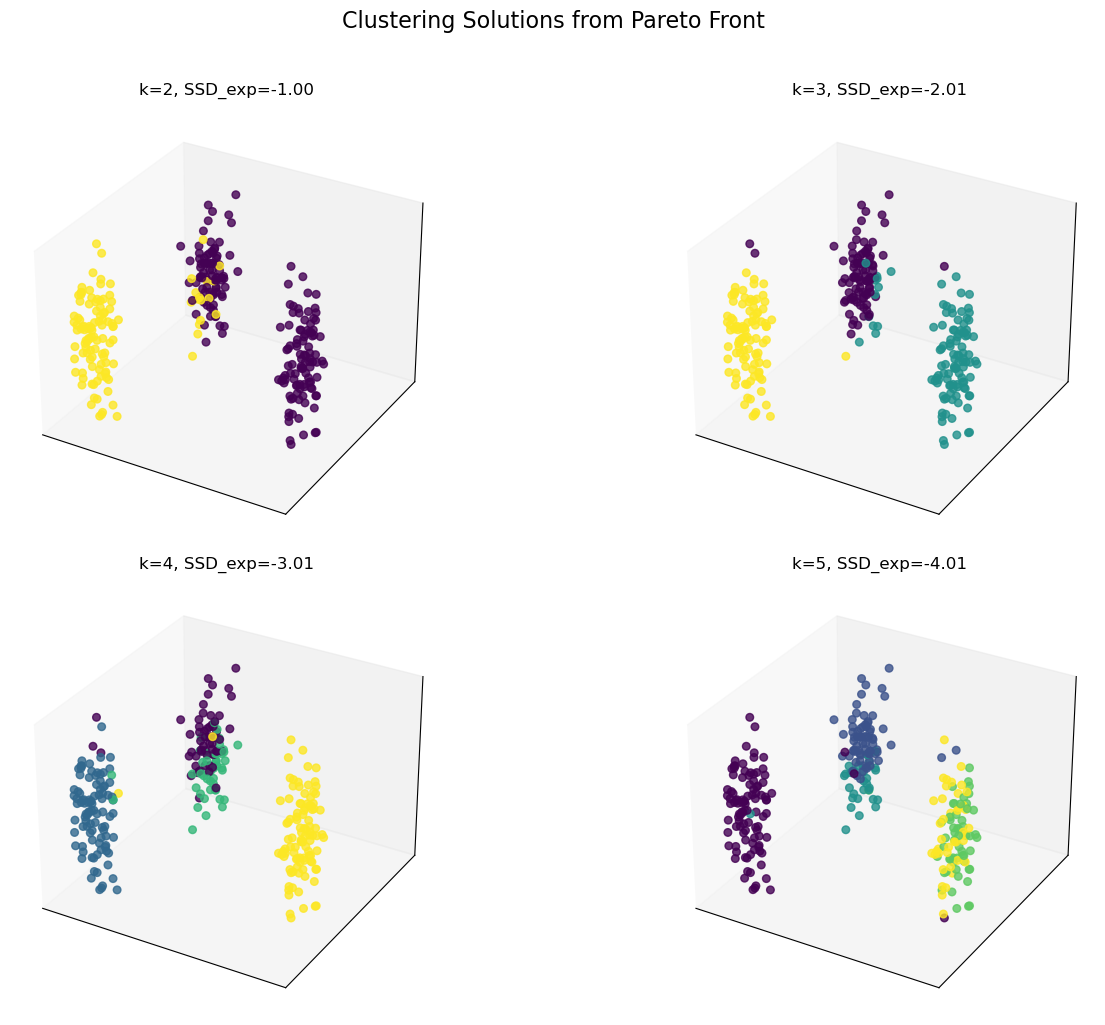

In [ ]:
def plot_pareto_solutions(model, X, max_solutions=6):
    # Get PCA projection
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)
    
    # Get Pareto front solutions
    pareto_front = model.get_pareto_front()
    
    # Sort solutions by k
    pareto_front.sort(key=lambda x: x[1][1])  # Sort by k value
    
    # Limit number of solutions to plot
    n_solutions = min(len(pareto_front), max_solutions)
    
    # Create figure
    n_cols = 2
    n_rows = (n_solutions + n_cols - 1) // n_cols
    fig = plt.figure(figsize=(15, 5*n_rows))
    fig.suptitle('Clustering Solutions from Pareto Front', y=1.02, fontsize=16)
    
    for idx, (sol, (ssd_exp, k)) in enumerate(pareto_front[:n_solutions]):
        # Get cluster labels for this solution
        k_int = int(k)  # Ensure k is integer
        centroids = sol.reshape(model.iemokc.k_max, -1)[:k_int]
        H = model.ae.encoder.predict(X)
        dists = cdist(H, centroids, 'euclidean')
        labels = np.argmin(dists, axis=1)
        
        # Create subplot
        ax = fig.add_subplot(n_rows, n_cols, idx+1, projection='3d')
        
        # Plot points with cluster colors
        scatter = ax.scatter(
            X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
            c=labels, cmap='viridis', s=30, alpha=0.8
        )
        
        # Add title with solution info
        ax.set_title(f'k={k_int}, SSD_exp={ssd_exp:.2f}', pad=10)
        
        # Remove axis ticks for cleaner look
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        
        # # Add colorbar
        # plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.1, label='Cluster')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# After running model.fit(X, k_true=3)
plot_pareto_solutions(model, X)

1. Initialize N valid chromosomes (solutions), each with:
   - k ∈ [2, kmax]
   - k centroids from H

2. For each generation (up to maxgen):
   a. Generate offspring (OS) using:
      - Simulated Binary Crossover (SBX)
      - Polynomial Mutation (PM)
   
   b. Combine parents + offspring → jointS (size 2N)
   
   c. Evaluate all solutions using:
      - f1(H): SSDexp
      - f2(H): number of clusters (k)
   
   d. Perform non-dominated sorting on jointS → separate into Pareto fronts
   
   e. Use crowding distance to preserve diversity
   
   f. Select N best solutions to form next generation

3. After maxgen generations:
   - Return final non-dominated Pareto front
